In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
import re
import time
import pickle

In [3]:
#Data scraping function
def data_scraping_date_city(date,city):

    driver = webdriver.Chrome('chromedriver.exe') # webdriver file directory
    driver.get("https://www.tjk.org/TR/YarisSever/Info/Page/GunlukYarisProgrami") # renders the race page
    #Gets date element and sends inputs
    element_date= driver.find_element_by_id("QueryParameter_Tarih")
    element_date.clear()
    element_date.send_keys(date)
    element_date.send_keys(Keys.ENTER)
    date = element_date.get_attribute("value")
    print(date)
    time.sleep(2)
    
    #Selects given city by user
    el = WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "#"+str(city))))
    el.click()
    time.sleep(2)
    
    day_thoroughbredid_list=[]
    day_jockeyid_list = []
    total_title_list=[]
    
    #Scraping horse id, jockey id and race title for each race
    for race_no in range (1,20):
        print(race_no)
        try:
            check_ele = driver.find_element_by_xpath("/html/body/div[1]/div[1]/div[6]/div[2]/div[2]/div[5]/div[2]/div[2]/div/div/div[4]/div["+str(race_no)+"]")
            title_ele = driver.find_element_by_xpath("/html/body/div[1]/div[1]/div[6]/div[2]/div[2]/div[5]/div[2]/div[2]/div/div/div[4]/div["+str(race_no)+"]/div[2]/h3[2]")
            print(title_ele.text)
            total_title_list.append(title_ele.text)
            race_horseid_list=[]
            race_jockeyid_list=[]
            for x in range (1,30):   
                try:
                    try:
                        horse_ele = driver.find_element_by_xpath("/html/body/div[1]/div[1]/div[6]/div[2]/div[2]/div[5]/div[2]/div[2]/div/div/div[4]/div["+str(race_no)+"]/div[10]/table/tbody/tr["+str(x)+"]/td[3]/a")
                    except:
                        horse_ele = driver.find_element_by_xpath("/html/body/div[1]/div[1]/div[6]/div[2]/div[2]/div[5]/div[2]/div[2]/div/div/div[4]/div["+str(race_no)+"]/div[5]/table/tbody/tr["+str(x)+"]/td[3]/a")
                    else:
                        pass
                    print(horse_ele.text)
                    link_horse = horse_ele.get_attribute('href')
                    horseid = re.search('AtId=(.+?)&Era', link_horse)
                    if horseid:
                        found_horseid = horseid.group(1)
                        print(found_horseid)
                        race_horseid_list.append(str(found_horseid))

                    try:
                        jockey_ele = driver.find_element_by_xpath("/html/body/div[1]/div[1]/div[6]/div[2]/div[2]/div[5]/div[2]/div[2]/div/div/div[4]/div["+str(race_no)+"]/div[10]/table/tbody/tr["+str(x)+"]/td[7]/a")
                    except:
                        jockey_ele = driver.find_element_by_xpath("/html/body/div[1]/div[1]/div[6]/div[2]/div[2]/div[5]/div[2]/div[2]/div/div/div[4]/div["+str(race_no)+"]/div[5]/table/tbody/tr["+str(x)+"]/td[7]/a")
                    else:
                        pass

                    print(jockey_ele.text)
                    link_jockey = jockey_ele.get_attribute('href')
                    jockeyid = re.search('JokeyId=(.+?)&Query', link_jockey)
                    if jockeyid:
                        found_jockeyid = jockeyid.group(1)
                        print(found_jockeyid)
                        race_jockeyid_list.append(str(found_jockeyid))

                except:
                    day_jockeyid_list.append(race_jockeyid_list)
                    day_thoroughbredid_list.append(race_horseid_list)
                    print('break')
                    break


        except:
            pass
    
    return total_title_list, day_jockeyid_list, day_thoroughbredid_list


In [4]:
def fetch_surface_distance_data(total_title_list):
    # Fetching track surface and distance informations of each race from title strings
    day_track_surface_list=[]
    day_distance_list=[]

    for x in total_title_list:
        if "Kum" in x:  # Kum means dirt in Turkish, if title includes "Dirt" adds to list "Dirt" else "Turf".

            # Gets distance as numbers placed just before surface information
            day_distance_list.append(int(re.findall(r"(\d+) Kum", x)[0]))

            day_track_surface_list.append("Dirt")  
            
        elif "Sentetik" in x: #Sentetik(Synthetic) is also considered as "Dirt"
            
            # Gets distance as numbers placed just before surface information
            day_distance_list.append(int(re.findall(r"(\d+) Sentetik", x)[0]))

            day_track_surface_list.append("Dirt")
            
        else:
            day_distance_list.append(int(re.findall(r"(\d+) Çim", x)[0]))
            day_track_surface_list.append("Turf") 
            
    return day_distance_list , day_track_surface_list

In [46]:
def make_prediction_and_plot(raceno):
    
    raceno-=1
    distance = day_distance_list[raceno]
    
    #Convert distance to categorical variable to filter dataframe
    if distance < 1450:
        distance= "short"
    elif 1450 < distance < 1950:
        distance= "middle"
    else:
        distance= "long"

    surface = day_track_surface_list[raceno]

    # Distance masked dataframe (picks data only includes distance of target race)
    df_mask_distance = df1[df1["distance_cat"]==distance]

    # Surface masked dataframe (picks data only includes surface of target race)
    df_mask_surface = df1[df1["surface"]==surface]

    # Both same surface and same distance category masked dataframe.
    df_double_mask = df_mask_distance[df_mask_distance["surface"]==surface]

    #Creates a dictionary with required column names
    test_set_dict_k1={"thoroughbred_id":[],"jockey_wa":[],"thoroughbred_surface_wa":[],"mother_surface_wa":[],
                       "father_surface_wa":[],"thoroughbred_distance_wa":[],"father_distance_wa":[],"mother_distance_wa":[],
                       "mother_general_wa":[],"father_general_wa":[]} # Wa means Weighted Average

    # Gets required features for validation set from main dataframe for each thoroughbred in that race
    for x in day_thoroughbredid_list[raceno]:
        x = int(x)
        test_set_dict_k1["thoroughbred_id"].append(x)

        #Fetches required all statistical data for test dataset
        try:
            thoroughbred_surface_wa_value = df_mask_surface[df_mask_surface["thoroughbred_id"]== x]["thoroughbred_surface_wa"].values[0]
        except: # if thoroughbred never ran before, raises exception
            print('Race No: '+str(raceno+1)+' / Thoroughbred id : '+str(x) +' never ran before. Might require human consideration')

            thoroughbred_surface_wa_value = 0
        test_set_dict_k1["thoroughbred_surface_wa"].append(thoroughbred_surface_wa_value)


        try:
            mother_surface_wa_value = df_mask_surface[df_mask_surface["thoroughbred_id"]== x]["mother_surface_wa"].values[0]
        except:
            mother_surface_wa_value = 0
        test_set_dict_k1["mother_surface_wa"].append(mother_surface_wa_value)

        try:
            father_surface_wa_value = df_mask_surface[df_mask_surface["thoroughbred_id"]== x]["father_surface_wa"].values[0]
        except:
            father_surface_wa_value = 0
        test_set_dict_k1["father_surface_wa"].append(father_surface_wa_value)

        try:
            thoroughbred_distance_wa_value = df_mask_distance[df_mask_distance["thoroughbred_id"]== x]["thoroughbred_distance_wa"].values[0]
        except:
            thoroughbred_distance_wa_value = 0
        test_set_dict_k1["thoroughbred_distance_wa"].append(thoroughbred_distance_wa_value)


        try:
            father_distance_wa_value = df_mask_distance[df_mask_distance["thoroughbred_id"]== x]["father_distance_wa"].values[0]
        except:
            father_distance_wa_value = 0
        test_set_dict_k1["father_distance_wa"].append(father_distance_wa_value)


        try:
            mother_distance_wa_value = df_mask_distance[df_mask_distance["thoroughbred_id"]== x]["mother_distance_wa"].values[0]
        except:
            mother_distance_wa_value = 0
        test_set_dict_k1["mother_distance_wa"].append(mother_distance_wa_value)


        try:
            mother_general_wa_value = df1[df1["thoroughbred_id"]== x]["mother_general_wa"].values[0]
        except:
            mother_general_wa_value = 0
        test_set_dict_k1["mother_general_wa"].append(mother_general_wa_value)


        try:
            father_general_wa_value = df1[df1["thoroughbred_id"]== x]["father_general_wa"].values[0]
        except:
            father_general_wa_value = 0
        test_set_dict_k1["father_general_wa"].append(father_general_wa_value)

    #Fetches jockeys statistics
    for x in day_jockeyid_list[raceno]:
        x = int(x)
        try:
            jockey_wa_value = df1[df1["jockey_id"]== x]["jockey_wa"].values[0]
        except:
            jockey_wa_value = 0
        test_set_dict_k1["jockey_wa"].append(jockey_wa_value)

    #Creates test set from gathered statistical data from main dataframe
    test_set = pd.DataFrame(test_set_dict_k1)
    del test_set["thoroughbred_id"]
    
    #Loading models from directory
    name = str(distance) + '_' + str(surface.lower())
    with open("models.pkl", "rb") as f:
        model_dict=pickle.load(f)
        
    models_list = model_dict[name]
            
    pred_list=[]
    
    #Making prediction with each model
    
    for x in models_list:
        pred_list.append(x.predict(test_set))
        
    #Creating dataframe from predicted values to plot a table
    df_pred_raw=pd.DataFrame(pred_list)
    df_pred_transposed=df_pred_raw.T
    len_test= len(test_set)
    idx = pd.Index(np.arange(1,len_test+1))
    df_pred_transposed.columns =["GradientBoostReg","KNNReg","LassoReg","RidgeReg","VotingReg"]
    df_pred_transposed.index=idx
    df_pred=df_pred_transposed.copy()
    
    #Plots prediction table
    title_text = 'RACE ' + str(raceno+1)

    len_test= len(test_set)
    idx = pd.Index(np.arange(1,len_test+1))
    df = df_pred
    vals = np.around(df.values,2)

    norm = plt.Normalize(vals.min()-1, vals.max()+1)
    colours = plt.cm.RdYlGn_r(norm(vals))

    fig = plt.figure(figsize=(13,8))
    ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.box(on=None)
    plt.subplots_adjust(left=0.1, bottom=0.3)
    the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                        loc='center', 
                        cellColours=colours)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(16)
    the_table.scale(1, 2)
    plt.suptitle(title_text)
    plt.show()

In [6]:
#Load main dataframe (It is not given to functions as input so should be always named as df1)
df1=pd.read_csv("12-18_04_2021_dataframe.csv",index_col = [0])

In [7]:
#Required race date and city input between 12-18/04/2021
date = "16/04/2021"
city = "Bursa"

In [9]:
#Calling data scraping functions with given inputs
total_title_list, day_jockeyid_list, day_thoroughbredid_list = data_scraping_date_city(date,city)
day_distance_list , day_track_surface_list = fetch_surface_distance_data(total_title_list)

16/04/2021
1
ŞARTLI 1 , 2 Yaşlı İngilizler, 57 kg, 800 Çim , E.İ.D. : 0.45.64
BOLD LION SURUÇ(1)
90085
T.YILDIZ
1264
EGEMERT(5)
89756
E.KADİRLER
2494
HALAF AĞA(2)
87772
O.GÖKÇE
1465
SMYRNA STORM(7)
86117
H.KAPLAN
2322
KARAKRALİÇE(4)
86478
OĞUZ EREN
941
TINY CHAMPION(6)
89481
O.ATMACA
566
WELCOME TO PROTİ(3)
89057
O.ÖZTÜRK
576
break
2
ŞARTLI 3/Dişi , 4 ve Yukarı İngilizler, 58 kg, 60 kg, 2100 Kum , E.İ.D. : 2.10.76
DİLİMYANDI(5)
75886
M.M.BİLGİN
2708
GO WING
76002
H.KAPLAN
2322
RUN FOR THE SUN(2)
68259
K.TOKAÇOĞLU
408
SPARK RACER(1)
73446
T.YILDIZ
1264
INNOCENT GHOST(3)
77666
N.AVCİ
1337
MISS TONYA(4)
77632
O.ÖZTÜRK
576
ONUR(6)
76469
S.ÖZEN
895
break
3
KV-6 , 4 ve Yukarı İngilizler, 58 kg, 59 kg, 1200 Çim , E.İ.D. : 1.06.62
NESTOR(1)
69156
T.YILDIZ
1264
QUEEN OF PROTI(7)
74708
O.ÖZTÜRK
576
HEROES(4)
79305
N.AVCİ
1337
HONORABLE(8)
74621
MAHMUT TURAN
1101
AIRDROP(9)
74211
H.KAPLAN
2322
KARA YAŞAR(5)
84156
İ.H.KETME
23
RAY OF SUNSHINE(10)
67420
N.ŞEN
549
FİNAL(6)
76955
S.İPEK
680
GOLD COUS

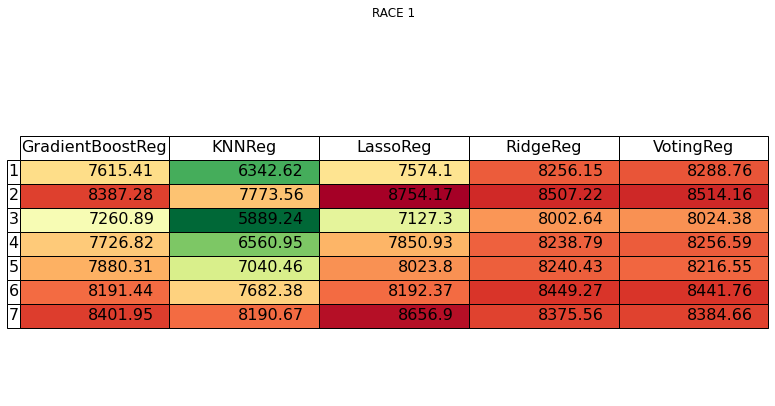

In [49]:
#Calling the function that makes predictions and plots results.
#Input = Race No
make_prediction_and_plot(1)